In [1]:
# general
import os
import sys
import time
import numpy as np 
import matplotlib.pyplot as plt 

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F 
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Numpyro
import numpyro
import numpyro.distributions as npdist
import random as rnd
from numpyro.infer import Predictive, init_to_median, MCMC, NUTS
from numpyro.diagnostics import hpdi

numpyro.set_host_device_count(4)

#JAX
import jax
from jax import random
import jax.numpy as jnp

# check versions
print(numpyro.__version__)
print(jax.__version__)
print(torch.__version__)
from platform import python_version
print(python_version())

0.10.1
0.3.25
1.12.1
3.8.16


In [2]:
# set device
torch.manual_seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed(0)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [55]:
args = {"seed": 0,
        
        # architecture
        "conditional": True,   # CVAE if True, VAE otherwise
        "input_dim": 80,
        "hidden_dim": 60,
        "z_dim": 40,
        
        # data generation
        "new_data": False,      # set to True to generate new data. Otherwise read from file
        "save_data": False,     # set to True to save generated training and test datasets
        "samples": 100000,
        
        # VAE setup
        "n_epochs": 1000,      
        "batch_size": 1000,
        "learning_rate": 1e-3,
        "train_vae": True,      # set to True to train VAE
        "save_vae": True,
        "load_vae": False,      # set to True to load trained CVAE
        "print_loss": True,
        "vae_sd": 0.1,
        "c_lin_true": 0.4,
       }

## GP priors

In [4]:
def lin_kernel(x,z, c_lin = 0.5, noise=0, jitter=1.0e-5):
    x = x.reshape(x.shape[0], 1)
    z = z.reshape(z.shape[0], 1)
    x_lin = x - c_lin
    z_lin = z - c_lin
    k = jnp.matmul(x_lin, jnp.transpose(z_lin))
    k += (noise + jitter) * jnp.eye(x.shape[0])
    return k

In [5]:
def dist_euclid(x, z):
    x = jnp.array(x) 
    z = jnp.array(z)
    if len(x.shape)==1:
        x = x.reshape(x.shape[0], 1)
    if len(z.shape)==1:
        z = z.reshape(z.shape[0], 1)
    n_x, m = x.shape
    n_z, m_z = z.shape
    assert m == m_z
    delta = jnp.zeros((n_x,n_z))
    for d in jnp.arange(m):
        x_d = x[:,d]
        z_d = z[:,d]
        delta += (x_d[:,jnp.newaxis] - z_d)**2
    return jnp.sqrt(delta)

def exp_sq_kernel(x, z, var, length, noise=0, jitter=1.0e-5):
    dist = dist_euclid(x, z)
    deltaXsq = jnp.power(dist/ length, 2.0)
    k = var * jnp.exp(-0.5 * deltaXsq)
    k += (noise + jitter) * jnp.eye(x.shape[0])
    return k

In [6]:
def plot_draws(draws, ttl="Priors we want to encode", ylbl='$y=f_{GP}(x)$', n_plot=30):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    for i in range(n_plot):
        ax.plot(x, draws[i,:])
    ax.set_xlabel('$x$')
    ax.set_ylabel(ylbl)
    ax.set_title(ttl)

In [7]:
def plot_draws_c(gp_draws, c_lin_draws, ttl="Priors we want to encode", ylbl='$y=f_{GP}(x)$', n_plot=30):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    for i in range(n_plot):
        r = np.round(np.random.rand(),1)
        g = np.round(np.random.rand(),1)
        b = np.round(np.random.rand(),1)
        ax.plot(x, gp_draws[i,:], color=[r,g,b])
        ax.axvline(c_lin_draws[i], color=[r,g,b])
    ax.set_xlabel('$x$')
    ax.set_ylabel(ylbl)
    ax.set_title(ttl)

In [8]:
def GP_lin_rbf(x, jitter=1e-5, var=1.0, length=None, y=None, noise=False, c_lin=None):

    if length==None:  
        length = numpyro.sample("length", npdist.Uniform(0.01,0.4)) 
        
    if c_lin==None:  
        c_lin = numpyro.sample("c_lin", npdist.Uniform(0.2,0.8))
            
    k_lin = lin_kernel(x, x, c_lin)
    k_rbf = exp_sq_kernel(x, x, var, length, jitter)
    k = jnp.multiply(k_lin, k_rbf)
    
    if noise==False:
        y = numpyro.sample("y",  npdist.MultivariateNormal(loc=jnp.zeros(x.shape[0]), covariance_matrix=k), obs=y)
    else:
        sigma = numpyro.sample("noise", npdist.HalfNormal(0.1))
        f = numpyro.sample("f", npdist.MultivariateNormal(loc=jnp.zeros(x.shape[0]), covariance_matrix=k))
        y = numpyro.sample("y", npdist.Normal(f, sigma), obs=y)
    
    ls = numpyro.deterministic("ls", jnp.array([length]))
    cl = numpyro.deterministic("cl", jnp.array([c_lin]))

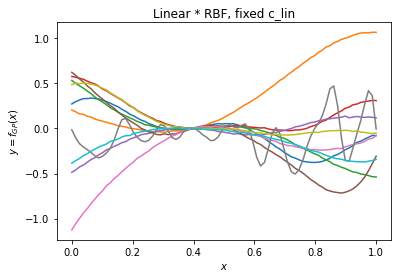

In [9]:
x = np.linspace(0, 1, 80)   

rng_key_draw =  random.PRNGKey(1)
rng_key, rng_key_post, rng_key_preds, rng_key_draw = random.split(rng_key_draw, 4)

gp_predictive = Predictive(GP_lin_rbf, num_samples=50)
draws = gp_predictive(rng_key_draw, x=x, jitter=1e-6, noise=False, c_lin=args["c_lin_true"])
gp_draws = draws['y']

plot_draws(gp_draws, ttl='Linear * RBF, fixed c_lin', n_plot=10)

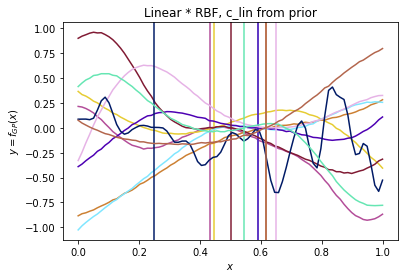

In [10]:
x = np.linspace(0, 1, 80)   

rng_key_draw =  random.PRNGKey(1)
rng_key, rng_key_post, rng_key_preds, rng_key_draw = random.split(rng_key_draw, 4)

gp_predictive = Predictive(GP_lin_rbf, num_samples=50)
draws = gp_predictive(rng_key_draw, x=x, jitter=1e-6, noise=False, c_lin=None)
gp_draws = draws['y']
c_lin_draws = draws['cl']

plot_draws_c(gp_draws, c_lin_draws, ttl='Linear * RBF, c_lin from prior', n_plot=10)

## Generate data - 1d GP

In [11]:
class GP1D(Dataset):
    def __init__(self, n_dataPoints=80, 
                       n_samples=10000, 
                       x_lim_low = 0, 
                       x_lim_high = 1,
                       cl = None,
                       ls = None,
                 
                 ): 
        self.n_dataPoints = n_dataPoints
        self.n_samples = n_samples
        self.x_lim_low = x_lim_low
        self.x_lim_high = x_lim_high
        self.ls = ls
        self.cl = cl
        self.x, self.y, self.ls, self.cl = self.__simulatedata__()
    
    def __len__(self):
        return self.n_samples
    
    def __getitem__(self, idx=0):
        return(self.x[idx], self.y[idx], self.ls[idx], self.cl[idx])

    def __simulatedata__(self):
        rng_key = rnd.randint(0, 912393890428)
        rng_key, _ = random.split(random.PRNGKey(rng_key))
        x = np.linspace(self.x_lim_low, self.x_lim_high, self.n_dataPoints)   
        gp_predictive = Predictive(GP_lin_rbf, num_samples=self.n_samples)  
        all_draws = gp_predictive(rng_key, x=x, jitter=1e-6, length=self.ls, c_lin=self.cl)

        ls_draws = np.array(all_draws['ls'])
        c_lin_draws = np.array(all_draws['cl'])
        gp_draws = np.array(all_draws['y'])
        
        return (x.repeat(self.n_samples).reshape(x.shape[0], self.n_samples).transpose(), gp_draws, ls_draws, c_lin_draws)

(0.0, 1.0)

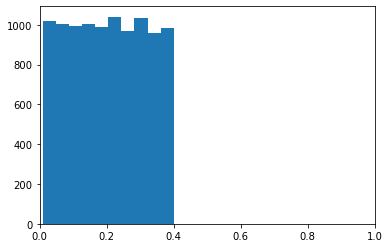

In [12]:
# what lengthscales are we generating?
dataset = GP1D(n_dataPoints=args["input_dim"])
ls_dataset = dataset.ls
plt.hist(ls_dataset) 
plt.xlim(0,1)

(0.0, 1.0)

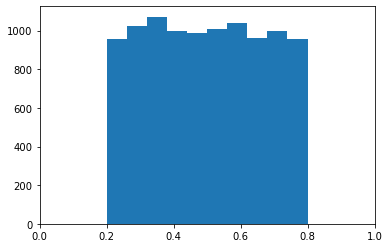

In [13]:
# what c_lin are we generating?
dataset = GP1D(n_dataPoints=args["input_dim"])
cl_dataset = dataset.cl
plt.hist(cl_dataset) 
plt.xlim(0,1)

In [14]:
ll = dataset[0][2]
cc = dataset[0][3]

In [15]:
c1 = torch.cat((torch.tensor(ll), torch.tensor(cc)))
c1

tensor([0.2569, 0.2254])

In [16]:
torch.cat((c1, torch.tensor(cc)))

tensor([0.2569, 0.2254, 0.2254])

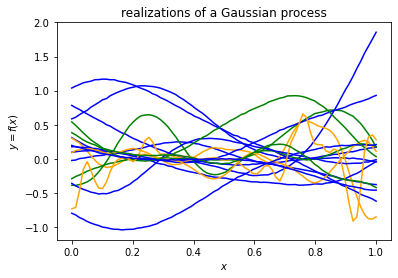

In [17]:
# what trajectories are we getting?
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

fig, ax = plt.subplots()
for no, dt in enumerate(dataloader):
    if dt[2] <= 0.1:
        col = 'orange'  
    elif dt[2] <= 0.2:
        col = 'green'
    else: 
        col = 'blue'
    ax.plot(dt[0].reshape(-1,1), dt[1].reshape(-1,1), color=col)
    if no > 15: break
ax.set_xlabel('$x$')
ax.set_ylabel('$y=f(x)$')
ax.set_title('realizations of a Gaussian process')

plt.show()

In [18]:
###### create or read training and test data
cwd = os.getcwd()
train_ds_name = 'gp1d_n' + str(args["input_dim"]) + '_lin_rbf_c_train.pt'
test_ds_name = 'gp1d_n' + str(args["input_dim"]) + '_lin_rbf_c_test.pt'
PATH_train = cwd+ F"/data/gp1d/{train_ds_name}" 
PATH_test =  cwd+F"/data/gp1d/{test_ds_name}" 
    
if args["new_data"] == True:
    print("Generating new data")
    train_ds = GP1D(n_dataPoints=args["input_dim"], n_samples=args["samples"], cl=None)
    test_ds = GP1D(n_dataPoints=args["input_dim"], n_samples=args["samples"], cl=None)
    torch.save(train_ds, PATH_train)
    torch.save(test_ds, PATH_test)
else:
    print("Loading data")
    train_ds = torch.load(PATH_train)
    test_ds = torch.load(PATH_test)
    
test_dl = DataLoader(test_ds, batch_size=args["batch_size"], shuffle=True)
train_dl = DataLoader(train_ds, batch_size=args["batch_size"], shuffle=True)

Loading data


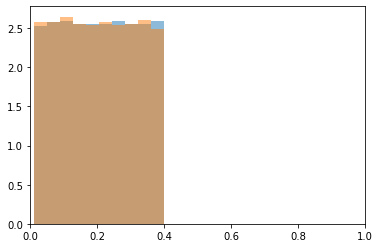

In [19]:
# check distribution of lengthscales in training and test data
ls_train = train_ds.ls
ls_test = test_ds.ls
plt.hist(ls_train, density=True, alpha=0.5) 
plt.hist(ls_test, density=True, alpha=0.5) 
plt.xlim(0,1)
plt.show()

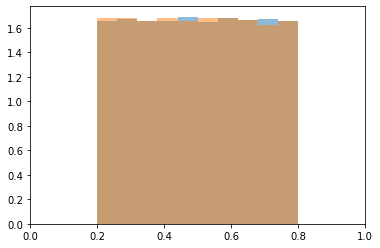

In [20]:
# check distribution of c_lin in training and test data
cl_train = train_ds.cl
cl_test = test_ds.cl
plt.hist(cl_train, density=True, alpha=0.5) 
plt.hist(cl_test, density=True, alpha=0.5) 
plt.xlim(0,1)
plt.show()

## CVAE architecture

In [21]:
class Encoder(nn.Module):
    ''' This the encoder part of CVAE
    '''
    def __init__(self, input_dim, hidden_dim, z_dim, conditional, num_conditions):
        super().__init__()
        self.conditional = conditional
        if self.conditional:
            input_dim = input_dim + num_conditions
        
        self.linear = nn.Linear(input_dim, hidden_dim)
        self.mu = nn.Linear(hidden_dim, z_dim)
        self.sd = nn.Linear(hidden_dim, z_dim)
        
    def forward(self, x, c=None):
        if self.conditional:
            #c = c[:, None]
            x = torch.cat((x, c), dim=-1)

        hidden = torch.relu(self.linear(x))
        z_mu = self.mu(hidden)
        z_sd = self.sd(hidden)
        return z_mu, z_sd


In [22]:
class Decoder(nn.Module):
    ''' This the decoder part of VAE
    '''
    def __init__(self,z_dim, hidden_dim, input_dim,  conditional, num_conditions):
        super().__init__()
        
        self.conditional = conditional
        if self.conditional:
            z_dim = z_dim + num_conditions
            
        self.linear = nn.Linear(z_dim, hidden_dim)
        self.out = nn.Linear(hidden_dim, input_dim)
    
    def forward(self, z, c):
        if self.conditional:
            z = torch.cat((z, c), dim=-1)

        hidden = torch.relu(self.linear(z))
        pred = self.out(hidden)
        return pred

In [23]:
class VAE(nn.Module):
    ''' This the VAE, which takes a encoder and decoder.
    '''
    def __init__(self, input_dim, hidden_dim, latent_dim,
                 conditional=False, num_conditions=0):
        
        super().__init__()        
        self.encoder = Encoder(input_dim, hidden_dim, latent_dim, conditional, num_conditions) 
        self.decoder = Decoder(latent_dim, hidden_dim, input_dim, conditional, num_conditions)

    def reparameterize(self, z_mu, z_sd):
        '''During training random sample from the learned ZDIMS-dimensional
           normal distribution; during inference its mean.
        '''
        if self.training:
            std = torch.exp(z_sd / 2)
            eps = torch.randn_like(std)
            return (eps.mul(std).add_(z_mu))
        else:
            return z_mu

    def forward(self, x, c=None):
        z_mu, z_sd = self.encoder(x, c)
        x_sample = self.reparameterize(z_mu, z_sd)
        generated_x = self.decoder(x_sample, c)
        return generated_x, z_mu,z_sd

In [24]:
def calculate_loss(y, reconstructed_y, mean, log_sd, vae_sd=args["vae_sd"]):

    # Compute the negative log-likelihood of the Gaussian distribution
    RCL = -torch.sum(- 0.5 * ((y - reconstructed_y) / vae_sd) ** 2)

    # Compute the KL divergence
    KLD = -0.5 * torch.sum(1 + log_sd - mean.pow(2) - log_sd.exp())

    return RCL + KLD

## Train PriorCVAE

In [25]:
# 1) Model
input_dim = args["input_dim"]
hidden_dim = args["hidden_dim"]
z_dim = args["z_dim"]
conditional = args["conditional"]
num_conditions = 2

model = VAE(input_dim, hidden_dim, z_dim, conditional, num_conditions)

# 2) optimizer
optimizer = optim.Adam(model.parameters(), lr=args["learning_rate"])       
device = 'cuda' if torch.cuda.is_available() else 'cpu' 
model = model.to(device)

loss_history_train = []
loss_history_test = []


In [26]:
def calc_loss(model, data, loss_fn):
    
    model.eval()
    with torch.no_grad():
        total_loss = 0

        for i, (_, y, ls, cl) in enumerate(data):    
            y = y.to(device)
            if args["conditional"]:
                ls = ls.to(device)
                cl = cl.to(device)
                c = torch.cat((ls, cl), dim=-1)
                reconstructed_y, z_mu, z_sd = model(y, c) 
            else:
                reconstructed_y, z_mu, z_sd = model(y)
                
            loss_i = loss_fn(y, reconstructed_y, z_mu, z_sd) 
            total_loss += loss_i.item()
            
    return total_loss / len(data)

Epoch 0: Train loss = 136243.2960, Test loss = 136887.6985
Epoch 1: Train loss = 88514.9278, Test loss = 88907.2196
Epoch 2: Train loss = 72928.2743, Test loss = 73372.9557
Epoch 3: Train loss = 66322.8927, Test loss = 66748.3745
Epoch 4: Train loss = 60423.0512, Test loss = 60841.3338
Epoch 5: Train loss = 54056.1941, Test loss = 54429.8211
Epoch 6: Train loss = 50435.2466, Test loss = 50791.4632
Epoch 7: Train loss = 46100.9223, Test loss = 46405.4710
Epoch 8: Train loss = 43557.6634, Test loss = 43808.8998
Epoch 9: Train loss = 42338.0764, Test loss = 42558.0381
Epoch 10: Train loss = 41704.7463, Test loss = 41909.6489
Epoch 11: Train loss = 41217.4528, Test loss = 41417.3610
Epoch 12: Train loss = 40811.7751, Test loss = 41008.1929
Epoch 13: Train loss = 40506.4930, Test loss = 40701.5311
Epoch 14: Train loss = 40197.8760, Test loss = 40389.3494
Epoch 15: Train loss = 39949.5948, Test loss = 40141.7209
Epoch 16: Train loss = 39669.4827, Test loss = 39859.6627
Epoch 17: Train loss =

Epoch 141: Train loss = 26580.5451, Test loss = 26730.8039
Epoch 142: Train loss = 26472.6553, Test loss = 26622.2160
Epoch 143: Train loss = 26594.5747, Test loss = 26741.2712
Epoch 144: Train loss = 26438.4225, Test loss = 26585.9205
Epoch 145: Train loss = 26463.9494, Test loss = 26615.1260
Epoch 146: Train loss = 26469.0201, Test loss = 26614.9995
Epoch 147: Train loss = 26457.2511, Test loss = 26602.8646
Epoch 148: Train loss = 26501.9942, Test loss = 26650.3211
Epoch 149: Train loss = 26428.6439, Test loss = 26570.9858
Epoch 150: Train loss = 26385.8228, Test loss = 26532.7694
Epoch 151: Train loss = 26412.1902, Test loss = 26556.8667
Epoch 152: Train loss = 26406.2630, Test loss = 26549.6251
Epoch 153: Train loss = 26331.0418, Test loss = 26477.6193
Epoch 154: Train loss = 26405.5727, Test loss = 26547.4356
Epoch 155: Train loss = 26349.7321, Test loss = 26494.3573
Epoch 156: Train loss = 26296.6670, Test loss = 26442.8963
Epoch 157: Train loss = 26322.0783, Test loss = 26464.85

Epoch 280: Train loss = 24823.6223, Test loss = 24967.3387
Epoch 281: Train loss = 24849.5629, Test loss = 24994.6728
Epoch 282: Train loss = 24834.3842, Test loss = 24981.3252
Epoch 283: Train loss = 24835.0606, Test loss = 24981.1864
Epoch 284: Train loss = 24845.5101, Test loss = 24990.4541
Epoch 285: Train loss = 24779.0556, Test loss = 24924.3533
Epoch 286: Train loss = 24919.3408, Test loss = 25063.1312
Epoch 287: Train loss = 24799.1805, Test loss = 24943.0974
Epoch 288: Train loss = 24778.4139, Test loss = 24920.6935
Epoch 289: Train loss = 24847.3910, Test loss = 24991.5776
Epoch 290: Train loss = 24822.4072, Test loss = 24968.5170
Epoch 291: Train loss = 24722.7236, Test loss = 24866.5516
Epoch 292: Train loss = 24734.8726, Test loss = 24883.3338
Epoch 293: Train loss = 24714.1173, Test loss = 24854.0675
Epoch 294: Train loss = 24736.2227, Test loss = 24879.0363
Epoch 295: Train loss = 24706.2283, Test loss = 24849.2143
Epoch 296: Train loss = 24716.9359, Test loss = 24860.49

Epoch 419: Train loss = 23644.6976, Test loss = 23766.4647
Epoch 420: Train loss = 23652.0648, Test loss = 23776.7204
Epoch 421: Train loss = 23560.0987, Test loss = 23679.9678
Epoch 422: Train loss = 23567.4770, Test loss = 23686.6647
Epoch 423: Train loss = 23581.1000, Test loss = 23702.2243
Epoch 424: Train loss = 23531.5087, Test loss = 23650.7060
Epoch 425: Train loss = 23573.2679, Test loss = 23693.2985
Epoch 426: Train loss = 23512.5510, Test loss = 23629.1144
Epoch 427: Train loss = 23532.3178, Test loss = 23655.6935
Epoch 428: Train loss = 23439.5979, Test loss = 23559.3412
Epoch 429: Train loss = 23524.8514, Test loss = 23645.9258
Epoch 430: Train loss = 23449.4933, Test loss = 23572.3261
Epoch 431: Train loss = 23524.9254, Test loss = 23644.0225
Epoch 432: Train loss = 23549.3275, Test loss = 23672.6688
Epoch 433: Train loss = 23472.0948, Test loss = 23597.5583
Epoch 434: Train loss = 23497.4944, Test loss = 23624.0010
Epoch 435: Train loss = 23556.1624, Test loss = 23676.40

Epoch 558: Train loss = 23296.6205, Test loss = 23423.3256
Epoch 559: Train loss = 23293.6264, Test loss = 23420.0538
Epoch 560: Train loss = 23301.9843, Test loss = 23427.8937
Epoch 561: Train loss = 23340.4452, Test loss = 23467.6416
Epoch 562: Train loss = 23313.5531, Test loss = 23440.2509
Epoch 563: Train loss = 23298.5312, Test loss = 23427.4896
Epoch 564: Train loss = 23285.6770, Test loss = 23416.5717
Epoch 565: Train loss = 23264.4993, Test loss = 23393.2601
Epoch 566: Train loss = 23306.5908, Test loss = 23431.0542
Epoch 567: Train loss = 23211.2104, Test loss = 23336.7701
Epoch 568: Train loss = 23291.9680, Test loss = 23418.3968
Epoch 569: Train loss = 23337.5598, Test loss = 23464.4924
Epoch 570: Train loss = 23224.8655, Test loss = 23351.9689
Epoch 571: Train loss = 23270.6223, Test loss = 23397.5926
Epoch 572: Train loss = 23279.3538, Test loss = 23406.6312
Epoch 573: Train loss = 23308.5730, Test loss = 23434.9209
Epoch 574: Train loss = 23292.3106, Test loss = 23419.80

Epoch 697: Train loss = 22951.1632, Test loss = 23082.5945
Epoch 698: Train loss = 23004.6929, Test loss = 23131.4340
Epoch 699: Train loss = 22917.2955, Test loss = 23046.4765
Epoch 700: Train loss = 22919.5177, Test loss = 23045.7749
Epoch 701: Train loss = 22953.2416, Test loss = 23082.5954
Epoch 702: Train loss = 22951.6159, Test loss = 23082.3602
Epoch 703: Train loss = 23000.9314, Test loss = 23131.1992
Epoch 704: Train loss = 22941.1858, Test loss = 23071.2840
Epoch 705: Train loss = 22940.1364, Test loss = 23071.6756
Epoch 706: Train loss = 22971.8528, Test loss = 23098.2964
Epoch 707: Train loss = 22950.5577, Test loss = 23079.2504
Epoch 708: Train loss = 22932.6518, Test loss = 23064.1723
Epoch 709: Train loss = 22908.4603, Test loss = 23035.8941
Epoch 710: Train loss = 22963.8395, Test loss = 23092.4994
Epoch 711: Train loss = 22896.2142, Test loss = 23023.6146
Epoch 712: Train loss = 22909.8949, Test loss = 23039.6048
Epoch 713: Train loss = 22894.9024, Test loss = 23021.52

Epoch 836: Train loss = 22758.6346, Test loss = 22885.9632
Epoch 837: Train loss = 22705.8760, Test loss = 22834.0666
Epoch 838: Train loss = 22750.5594, Test loss = 22883.7481
Epoch 839: Train loss = 22711.0660, Test loss = 22836.2268
Epoch 840: Train loss = 22790.7401, Test loss = 22920.0705
Epoch 841: Train loss = 22732.1172, Test loss = 22854.3840
Epoch 842: Train loss = 22773.2850, Test loss = 22902.6547
Epoch 843: Train loss = 22821.6679, Test loss = 22950.3429
Epoch 844: Train loss = 22780.6972, Test loss = 22906.3893
Epoch 845: Train loss = 22765.7657, Test loss = 22892.9223
Epoch 846: Train loss = 22789.9073, Test loss = 22914.3186
Epoch 847: Train loss = 22758.9567, Test loss = 22889.3281
Epoch 848: Train loss = 22765.1758, Test loss = 22888.8396
Epoch 849: Train loss = 22792.3008, Test loss = 22915.3970
Epoch 850: Train loss = 22729.0337, Test loss = 22853.0286
Epoch 851: Train loss = 22690.0838, Test loss = 22817.2885
Epoch 852: Train loss = 22661.9007, Test loss = 22784.03

Epoch 975: Train loss = 22460.4861, Test loss = 22578.2058
Epoch 976: Train loss = 22484.8479, Test loss = 22602.9223
Epoch 977: Train loss = 22459.2455, Test loss = 22577.2631
Epoch 978: Train loss = 22526.8427, Test loss = 22649.8866
Epoch 979: Train loss = 22492.7137, Test loss = 22613.1748
Epoch 980: Train loss = 22420.5187, Test loss = 22536.2875
Epoch 981: Train loss = 22499.0225, Test loss = 22616.5928
Epoch 982: Train loss = 22498.2248, Test loss = 22615.5107
Epoch 983: Train loss = 22510.6978, Test loss = 22625.9047
Epoch 984: Train loss = 22467.5727, Test loss = 22587.2093
Epoch 985: Train loss = 22478.5638, Test loss = 22594.2359
Epoch 986: Train loss = 22518.4593, Test loss = 22637.0560
Epoch 987: Train loss = 22438.4205, Test loss = 22557.0060
Epoch 988: Train loss = 22423.4082, Test loss = 22540.8478
Epoch 989: Train loss = 22445.6786, Test loss = 22560.8894
Epoch 990: Train loss = 22406.6118, Test loss = 22515.7003
Epoch 991: Train loss = 22406.0196, Test loss = 22521.63

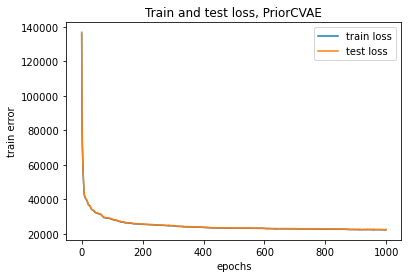

In [27]:
num_epochs = args['n_epochs']

best_model = model

if args["train_vae"] == True:
    
    start_time = time.time()

    for epoch in range(num_epochs):
        
        # Set the model back to training mode
        model.train(True)
        
        # batch training
        for i, (_, y, ls, cl) in enumerate(train_dl):

            # Clear the gradients
            optimizer.zero_grad()
            
            # Forward pass
            y = y.to(device)

            if args["conditional"]:
                ls = ls.to(device)
                cl = cl.to(device)
                c = torch.cat((ls, cl), dim=-1)
                reconstructed_y, z_mu, z_sd = model(y, c) 
            else:
                reconstructed_y, z_mu, z_sd = model(y)
                
            # training loss on the batch    
            loss_tr = calculate_loss(y, reconstructed_y, z_mu, z_sd) 
            
            # Backward pass
            loss_tr.backward()
    
            # Update the weights
            optimizer.step()
            
        # Calculate the training loss for the epoch
        train_loss = calc_loss(model, train_dl, calculate_loss)
        loss_history_train.append(train_loss)
        
        # Set the model to evaluation mode
        model.eval()
  
        # Calculate the test loss for the epoch
        test_loss = calc_loss(model, test_dl, calculate_loss)
        loss_history_test.append(test_loss)
        
        if epoch==0:
            best_loss = test_loss
        else:
            if test_loss < best_loss:
                best_model = model
                best_loss = test_loss
        
        # Print loss
        if args["print_loss"] == True:
            print(f"Epoch {epoch}: Train loss = {train_loss:.4f}, Test loss = {test_loss:.4f}")
        
    end_time = time.time()
    t_elapsed = end_time - start_time
    
    # Print elapsed time
    print(f"Elapsed time = {t_elapsed:.4f}")

    plt.figure()
    plt.plot(np.arange(len(loss_history_train)), loss_history_train, label="train loss")
    plt.plot(np.arange(len(loss_history_test)), loss_history_test, label="test loss")
    plt.xlabel("epochs")
    plt.ylabel("train error")
    plt.legend()
    plt.title("Train and test loss, PriorCVAE")
    plt.show()

In [29]:
# Print elapsed time
print(f"Elapsed time = {t_elapsed:.4f} s")
print(f"Elapsed time = {t_elapsed/60:.4f} min")
print(f"Elapsed time = {t_elapsed/(60*60):.4f} h")

Elapsed time = 3033.8797 s
Elapsed time = 50.5647 min
Elapsed time = 0.8427 h


In [56]:
args["save_vae"]

True

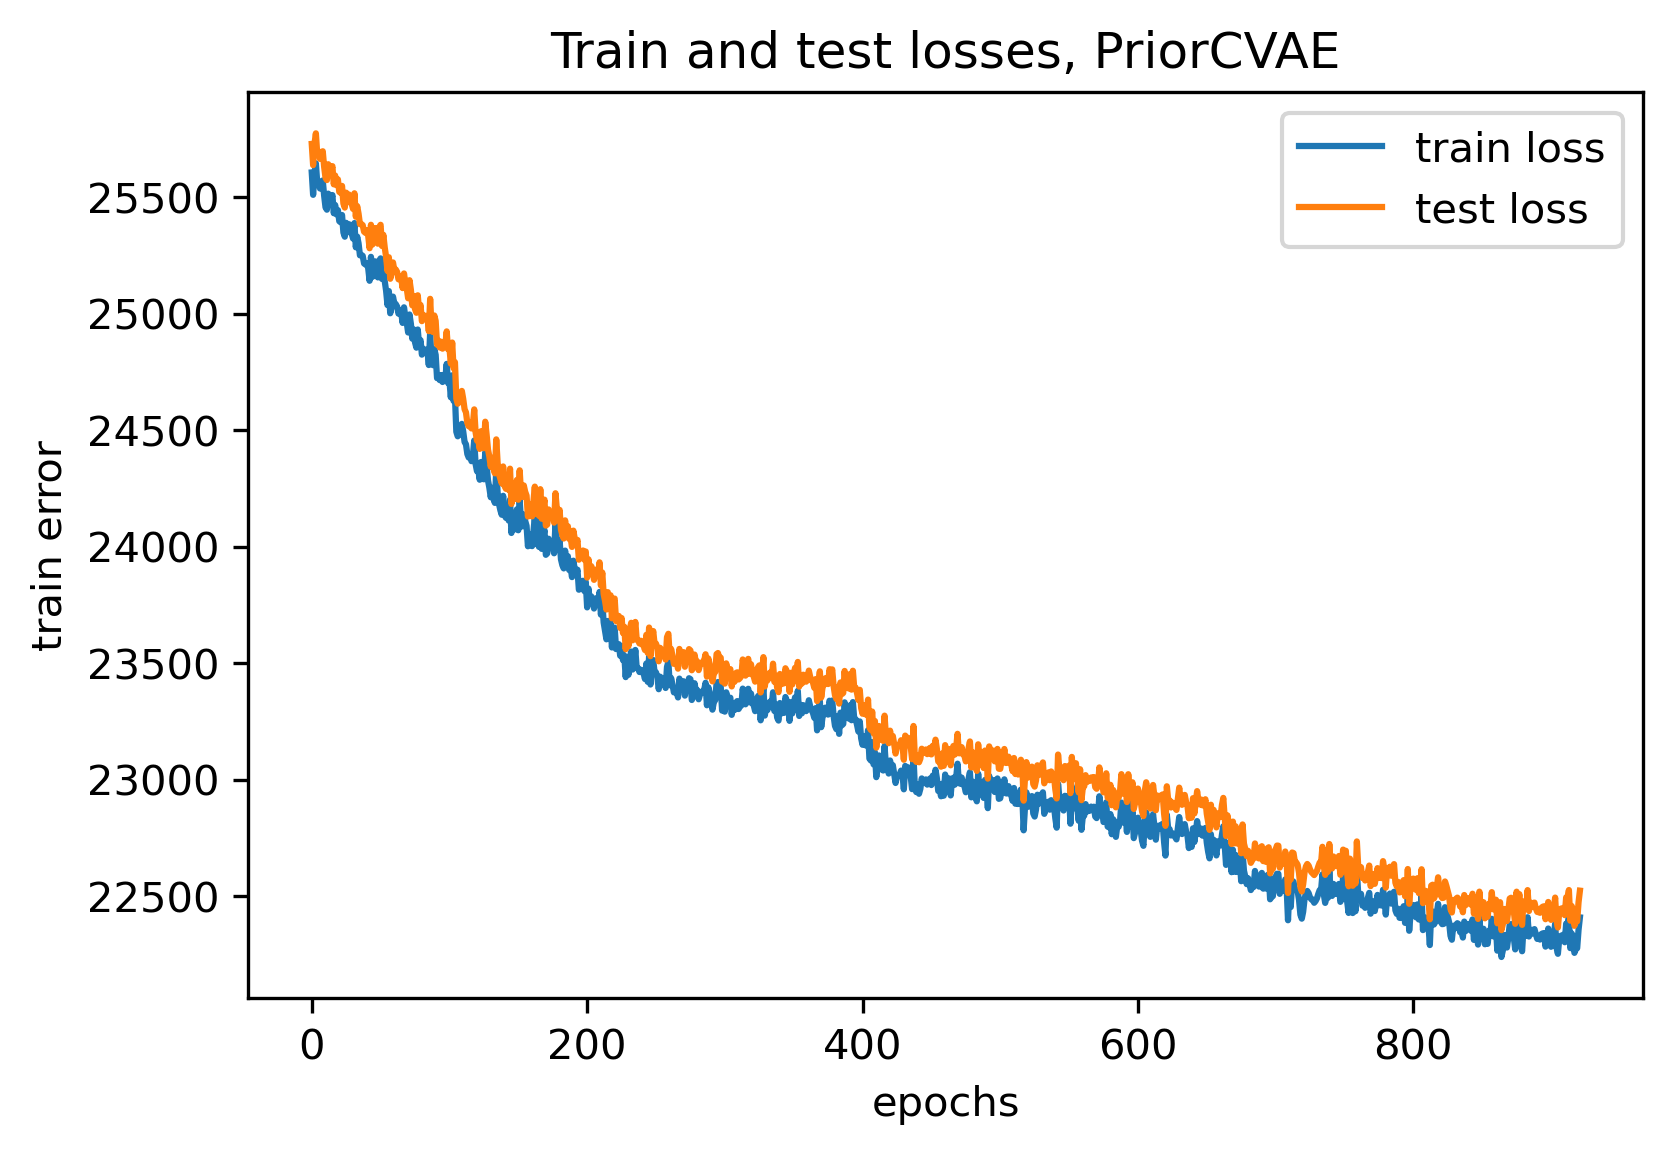

In [57]:
# plot the latest epochs 

start_ind = 200

plt.figure()
plt.plot(np.arange(len(loss_history_train[start_ind:])), loss_history_train[start_ind:], label="train loss")
plt.plot(np.arange(len(loss_history_test[start_ind:])), loss_history_test[start_ind:], label="test loss")
plt.xlabel("epochs")
plt.ylabel("train error")
plt.legend()
plt.title("Train and test losses, PriorCVAE")
plt.show()

In [58]:
model.state_dict()['encoder.linear.weight'] == best_model.state_dict()['encoder.linear.weight']

NameError: name 'best_model' is not defined

In [59]:
model = best_model
del best_model

NameError: name 'best_model' is not defined

In [60]:
import pickle

model_save_name = 'PriorCVAE_gp1d_n'+str(args["input_dim"])+'_h'+str(args["hidden_dim"])+'_z'+str(args["z_dim"])+'_epochs'+str(args["n_epochs"])+'_b'+str(args["batch_size"]) + '_lin_rbf_c.pt'
loss_train_name = 'PriorCVAE_gp1d_n'+str(args["input_dim"])+'_h'+str(args["hidden_dim"])+'_z'+str(args["z_dim"])+'_epochs'+str(args["n_epochs"])+'_b'+str(args["batch_size"]) +'_loss_train_lin_rbf_c'
loss_test_name =  'PriorCVAE_gp1d_n'+str(args["input_dim"])+'_h'+str(args["hidden_dim"])+'_z'+str(args["z_dim"])+'_epochs'+str(args["n_epochs"])+'_b'+str(args["batch_size"]) +'_loss_test_lin_rbf_c'
print(model_save_name) 
print(loss_train_name) 
print(loss_test_name) 

PATH = cwd + F"/trained_models/{model_save_name}" 
loss_train_name = cwd +"/trained_models/" + loss_train_name
loss_test_name = cwd + "/trained_models/" + loss_test_name

if args["save_vae"] == True:    
    print("VAE model saved")
    torch.save(model.state_dict(), PATH)
    
    with open(loss_train_name, "wb") as fp:  
        pickle.dump(loss_history_train, fp)
    with open(loss_test_name, "wb") as fp:  
        pickle.dump(loss_history_test, fp)
        
elif args["load_vae"] == True:
    model.load_state_dict(torch.load(PATH))
    
    with open(loss_train_name, "rb") as fp:   
        loss_history_train = pickle.load(fp)
    with open(loss_test_name, "rb") as fp:   
        loss_history_test = pickle.load(fp)

    print("CVAE model loaded")
else:
    print("no model loaded")



PriorCVAE_gp1d_n80_h60_z40_epochs1000_b1000_lin_rbf_c.pt
PriorCVAE_gp1d_n80_h60_z40_epochs1000_b1000_loss_train_lin_rbf_c
PriorCVAE_gp1d_n80_h60_z40_epochs1000_b1000_loss_test_lin_rbf_c
VAE model saved


## Visual diagnostics of how well we have learnt

In [35]:
def MMD(x, y, kernel="multiscale"):
    """Emprical maximum mean discrepancy. The lower the result, the more evidence that distributions are the same.

    Args:
        x: first sample, distribution P
        y: second sample, distribution Q
        kernel: kernel type such as "multiscale" or "rbf"
    """
    xx, yy, zz = torch.mm(x, x.t()), torch.mm(y, y.t()), torch.mm(x, y.t())
    rx = (xx.diag().unsqueeze(0).expand_as(xx))
    ry = (yy.diag().unsqueeze(0).expand_as(yy))
    
    dxx = rx.t() + rx - 2. * xx # Used for A in (1)
    dyy = ry.t() + ry - 2. * yy # Used for B in (1)
    dxy = rx.t() + ry - 2. * zz # Used for C in (1)
    
    XX, YY, XY = (torch.zeros(xx.shape).to(device),
                  torch.zeros(xx.shape).to(device),
                  torch.zeros(xx.shape).to(device))
    
    if kernel == "multiscale":
        
        bandwidth_range = [0.2, 0.5, 0.9, 1.3]
        for a in bandwidth_range:
            XX += a**2 * (a**2 + dxx)**-1
            YY += a**2 * (a**2 + dyy)**-1
            XY += a**2 * (a**2 + dxy)**-1
            
    if kernel == "rbf":
      
        bandwidth_range = [10, 15, 20, 50]
        for a in bandwidth_range:
            XX += torch.exp(-0.5*dxx/a)
            YY += torch.exp(-0.5*dyy/a)
            XY += torch.exp(-0.5*dxy/a)
      
    return torch.mean(XX + YY - 2. * XY)

In [36]:
def demo_plots(conditional =False, 
               ttl1="GP priors to encode",
               ttl2="Priors learnt by PriorVAE", 
               ylbl1='$y=f_{GP}(x)$', 
               ylbl2='$y=f_{PriorVAE}(x)$', 
               ls=None,
               cl=None,
               plot_draws = True,
               plot_cov =True,
               print_MMD = True):

    n_samps = 100000
    if conditional == True:
        dataset = GP1D(n_dataPoints=args["input_dim"], n_samples=n_samps, ls=ls, cl=cl)
        ttl2="Priors learnt by PriorCVAE"
        ylbl2='$y=f_{PriorCVAE}(x)$'
    else:
        dataset = GP1D(n_dataPoints=args["input_dim"], n_samples=n_samps, ls=ls, cl=cl)    

    gp_draws = dataset.y
    x = dataset.x[0,:]
    gp_draws = gp_draws.transpose()

    model.eval() # model in eval mode
    z = torch.randn(n_samps, z_dim).to(device) # random draw

    if conditional == True:
        ls_torch = torch.ones(n_samps) * ls
        ls_torch = ls_torch[:, None]
        cl_torch = torch.ones(n_samps) * cl
        cl_torch = cl_torch[:, None]
        c = torch.cat((ls_torch, cl_torch), dim=-1)
        with torch.no_grad():
            vae_draws = model.decoder(z, c).numpy().transpose()
    else:
        with torch.no_grad():
            vae_draws = model.decoder(z, c=None).numpy().transpose()

    mean_gp = np.nanmean(gp_draws, axis=1)
    q025_gp = np.quantile(gp_draws, 0.025, axis=1)
    q975_gp = np.quantile(gp_draws, 0.975, axis=1)
    #print(mean_gp.shape)

    mean_vae = np.nanmean(vae_draws, axis=1)
    q025_vae = np.quantile(vae_draws, 0.025, axis=1)
    q975_vae = np.quantile(vae_draws, 0.975, axis=1)

    #print("q025: ")
    #print(q025_gp)
    #print(q025_vae)
    #print("q975: ")
    #print(q975_gp)
    #print(q975_vae)

    
    if plot_draws==True:
        # plot results
        fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15,4))

        _min, _max = -2, 2
        lines_alpha_gp = 0.5
        lines_alpha_vae = 0.5
        N_lines = 20

        if ls==None:
            ttl = ttl1
        else:
            ttl = ttl1+ ", $l=$" + str(ls) + ", $cl=$" + str(cl)
        ylbl = ylbl1

        for j in range(N_lines):
            itr = int(gp_draws.shape[1]/N_lines)
            axs[0].plot(x, gp_draws[:,j*itr], alpha=lines_alpha_gp, label="", color="darkgreen", linewidth=0.8)
            

        axs[0].plot(x, gp_draws[:,0], alpha=lines_alpha_gp, color="darkgreen", label="GP draws")  
        axs[0].fill_between(x, q025_gp, q975_gp, alpha=0.1, interpolate=True, label="95% BCI")
        axs[0].plot(x, mean_gp, label="mean")
        axs[0].legend(loc=4)
        axs[0].set_ylim([_min, _max])
        axs[0].set_xlabel('$x$')
        axs[0].set_ylabel(ylbl)
        axs[0].set_title(ttl)

        if ls==None:
            tt2 = ttl2
        else:
            tt2 = ttl2+ ", $l=$" + str(ls)+ ", $cl=$" + str(cl)
        ylbl=ylbl2

        for j in range(N_lines):
            itr = int(vae_draws.shape[1]/N_lines)
            axs[1].plot(x, vae_draws[:,j*itr], alpha=lines_alpha_vae, label="", color="darkgreen", linewidth=0.8)

        axs[1].plot(x, vae_draws[:,0], alpha=lines_alpha_vae, color="darkgreen", label="PriorCVAE draws")  
        axs[1].fill_between(x, q025_vae, q975_vae, alpha=0.1, interpolate=True, label="95% BCI")
        axs[1].plot(x, mean_vae, label="mean")
        axs[1].legend(loc=4)
        axs[1].set_ylim([_min, _max])
        axs[1].set_xlabel('$x$')
        axs[1].set_ylabel(ylbl)
        axs[1].set_title(tt2)

        axs[2].plot(x, mean_gp, label="mean, GP")
        axs[2].fill_between(x, q025_gp, q975_gp, alpha=0.4, interpolate=True, label="95% BCI, GP")
        axs[2].plot(x, mean_vae, label="mean, PriorCVAE")
        axs[2].fill_between(x, q025_vae, q975_vae, alpha=0.4, interpolate=True, label="95% BCI, PriorCVAE")
        axs[2].legend(loc=4)
        axs[2].set_ylim([_min, _max])
        axs[2].set_title("Comparison of first and second moments")
        axs[2].set_xlabel('$x$')

        #plt.show()
        
    m_vae = np.cov((vae_draws))
    m_gp = np.cov((gp_draws))


    if print_MMD==True:
        print('Frobenius norm = ' + str(np.linalg.norm(m_gp - m_vae,  'fro')))    
        gg = torch.from_numpy(gp_draws)
        vv = torch.from_numpy(vae_draws)
        print('MMD, multiscale = ' + str(MMD(gg, vv)))
        print('MMD, rbf = ' + str(MMD(gg, vv, "rbf")))
    
        
    if plot_cov==True:
        cmap_choice = 'inferno'
    
        gp_cm_ttl = 'GP covariance matrix'
        if ls is not None:
            gp_cm_ttl = gp_cm_ttl + ', $l=$'+ str(ls)+ ", $cl=$" + str(cl)
        vae_cm_ttl = 'VAE covariance matrix'
        if conditional == True:
            vae_cm_ttl = 'C' + vae_cm_ttl
        if ls is not None:
            vae_cm_ttl = vae_cm_ttl +', $l=$'+ str(ls)+ ", $cl=$" + str(cl)

        #'plasma'
        #'inferno'
        fig, axs = plt.subplots(nrows=1, ncols=2, figsize = (8,4))
        axs[0].imshow(m_gp, cmap=cmap_choice)
        axs[0].axis('off')
        axs[0].set_title(gp_cm_ttl)

        axs[1].imshow(m_vae, cmap=cmap_choice)
        axs[1].axis('off')
        axs[1].set_title(vae_cm_ttl)

        #plt.show()

        #return (gp_draws, vae_draws)

In [37]:
# there plots create motivation:
# 1).     unceratinty interval does not exactly match the oroginal one. This is due to the MSE loss. 
#         We can change it either to likelihood with variance which is not one, or use beta-VAE, or MMD.
# 2).     VAE has learnt the best draws with ls=0.5 (Frob norm = 5.7)
# 3), 4). VAE has not learnt draws with ls values on the edge of the interval well (Frob norm = 20.3)

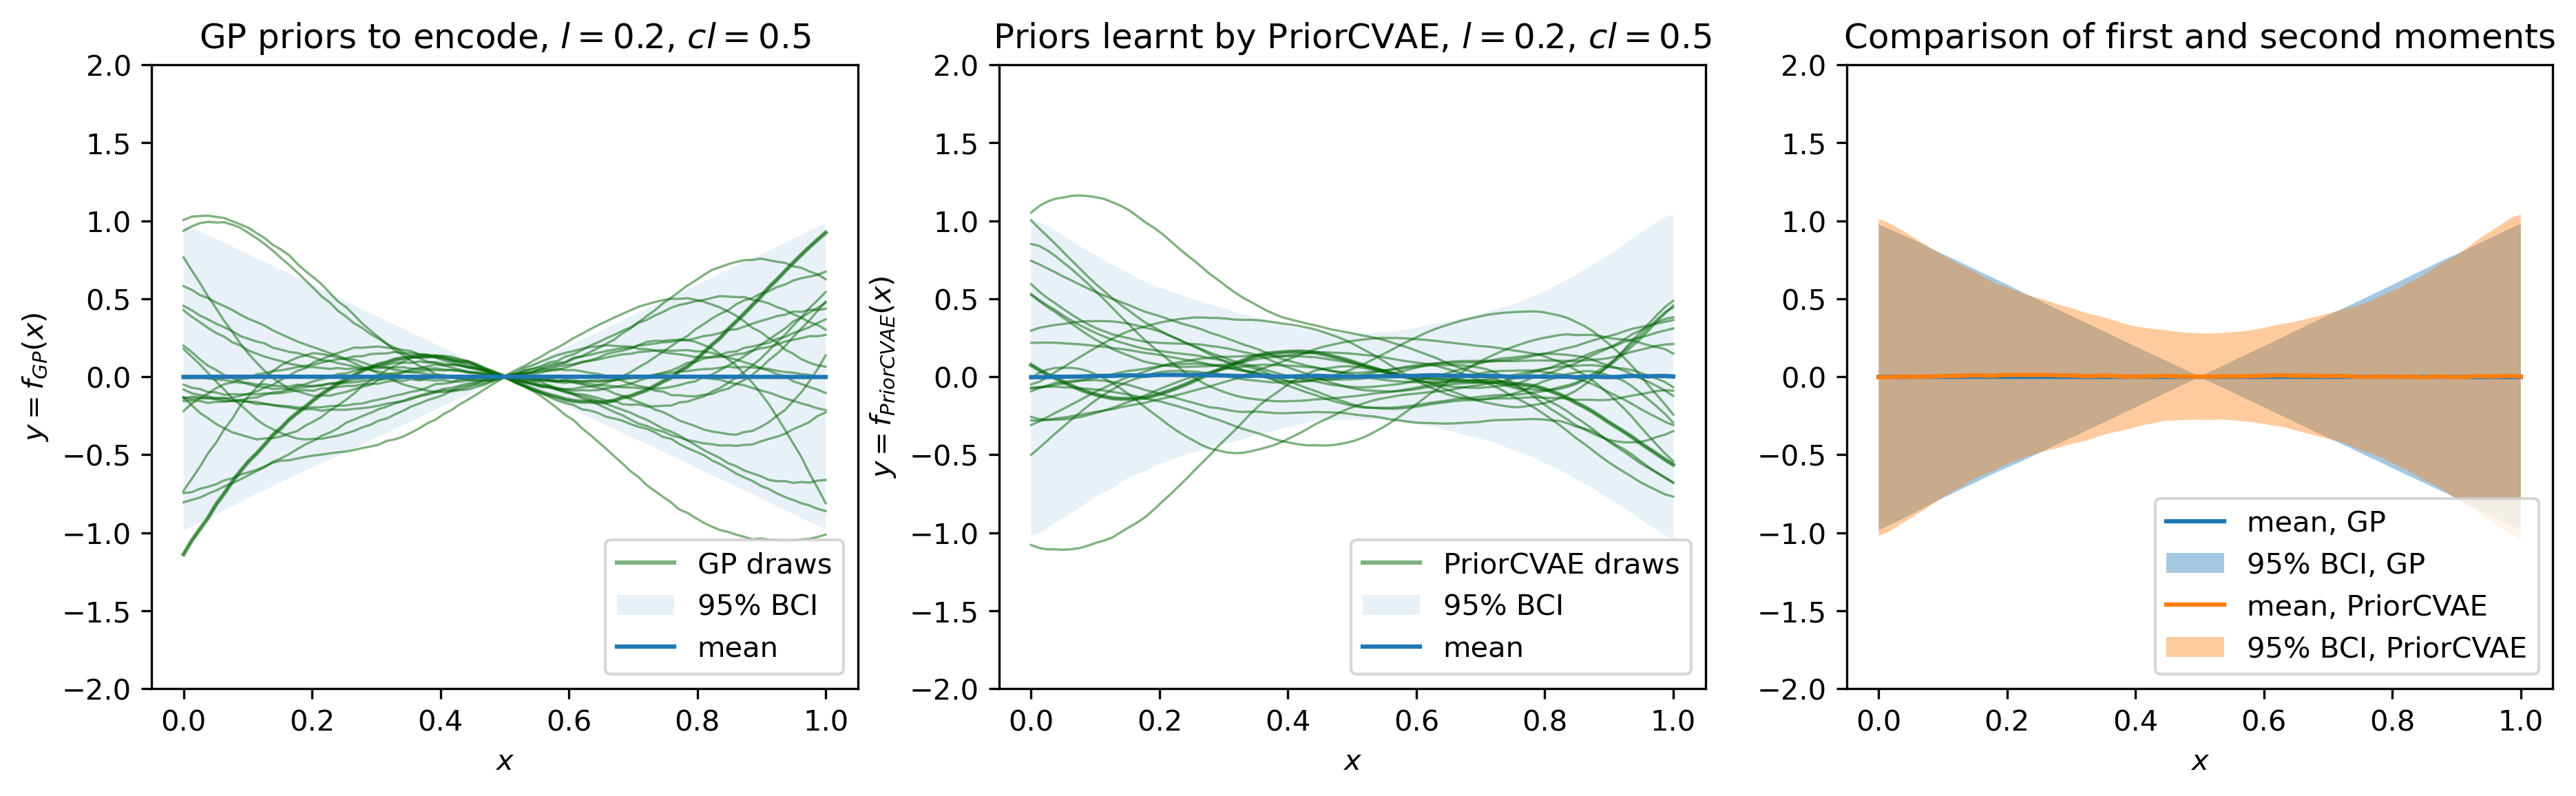

In [53]:
demo_plots(conditional=True, ls=0.2, cl=0.5, plot_draws = True, plot_cov =False, print_MMD = False)

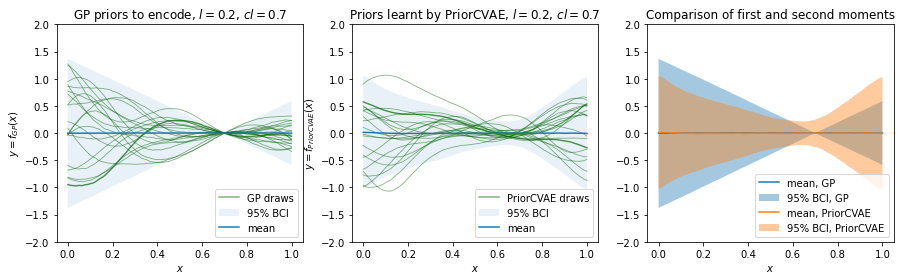

In [38]:
# 2).

demo_plots(conditional=True, ls=0.2, cl=0.7, plot_draws = True, plot_cov =False, print_MMD = False)

n = args["input_dim"]
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
#plt.savefig('res/1d_n{}_lin_rbf_priors_ls02.pdf'.format(n))

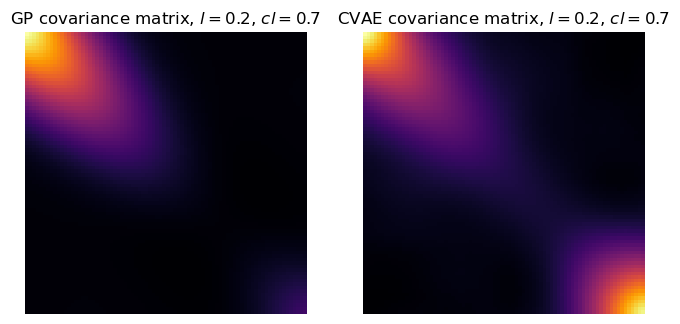

In [40]:
demo_plots(conditional=True, ls=0.2, cl=0.7, plot_draws = False, plot_cov =True, print_MMD = False)

plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 100
#plt.savefig('res/1d_n{}_GP_lin_rbf_cov_mats_ls02.pdf'.format(n))

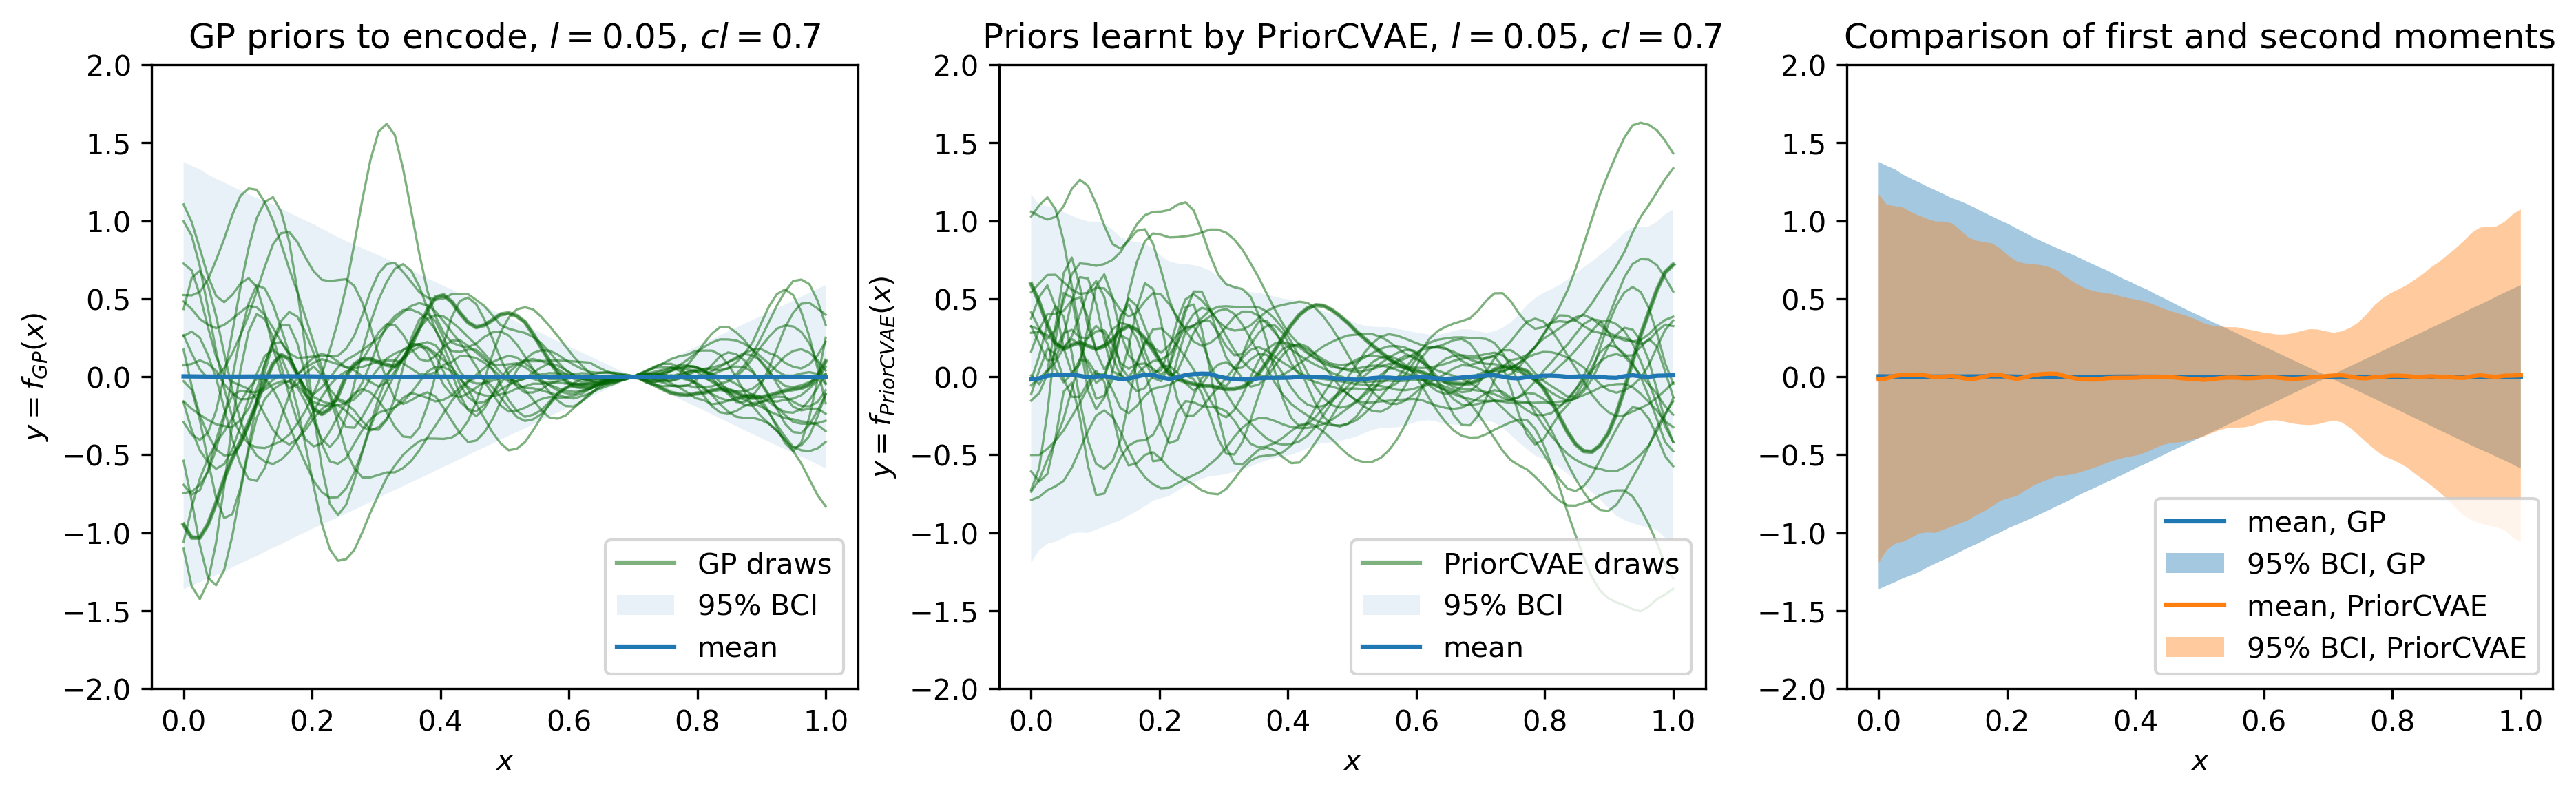

In [42]:
# 3).
demo_plots(conditional=True, ls=0.05, cl=0.7, plot_draws = True, plot_cov =False, print_MMD = False)

plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
#plt.savefig('res/1d_n{}_lin_rbf_priors_ls005.pdf'.format(n))

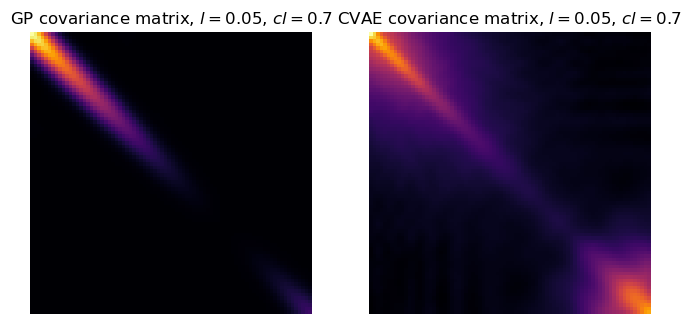

In [44]:
demo_plots(conditional=True, ls=0.05, cl=0.7, plot_draws = False, plot_cov =True, print_MMD = False)

plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 100
#plt.savefig('res/1d_n{}_GP_lin_rbf_cov_mats_ls005.pdf'.format(n))

Frobenius norm = 3.208173620338344
MMD, multiscale = tensor(0.1027)
MMD, rbf = tensor(0.1389)


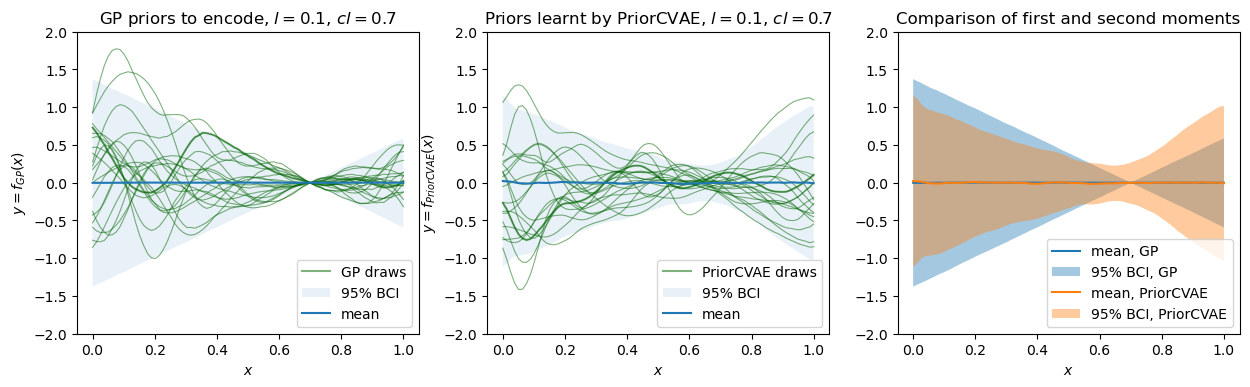

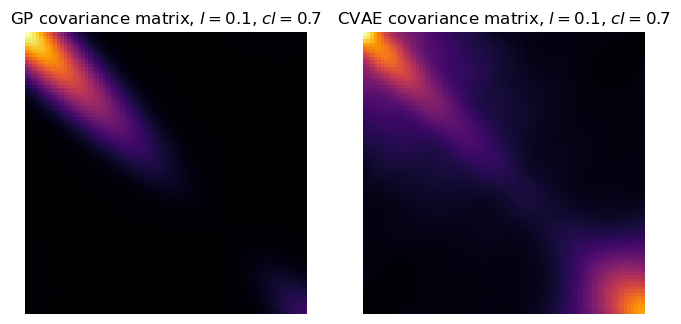

In [45]:
# 3).
demo_plots(conditional=True, ls=0.1, cl=0.7)

## Extrapolate lengthscale

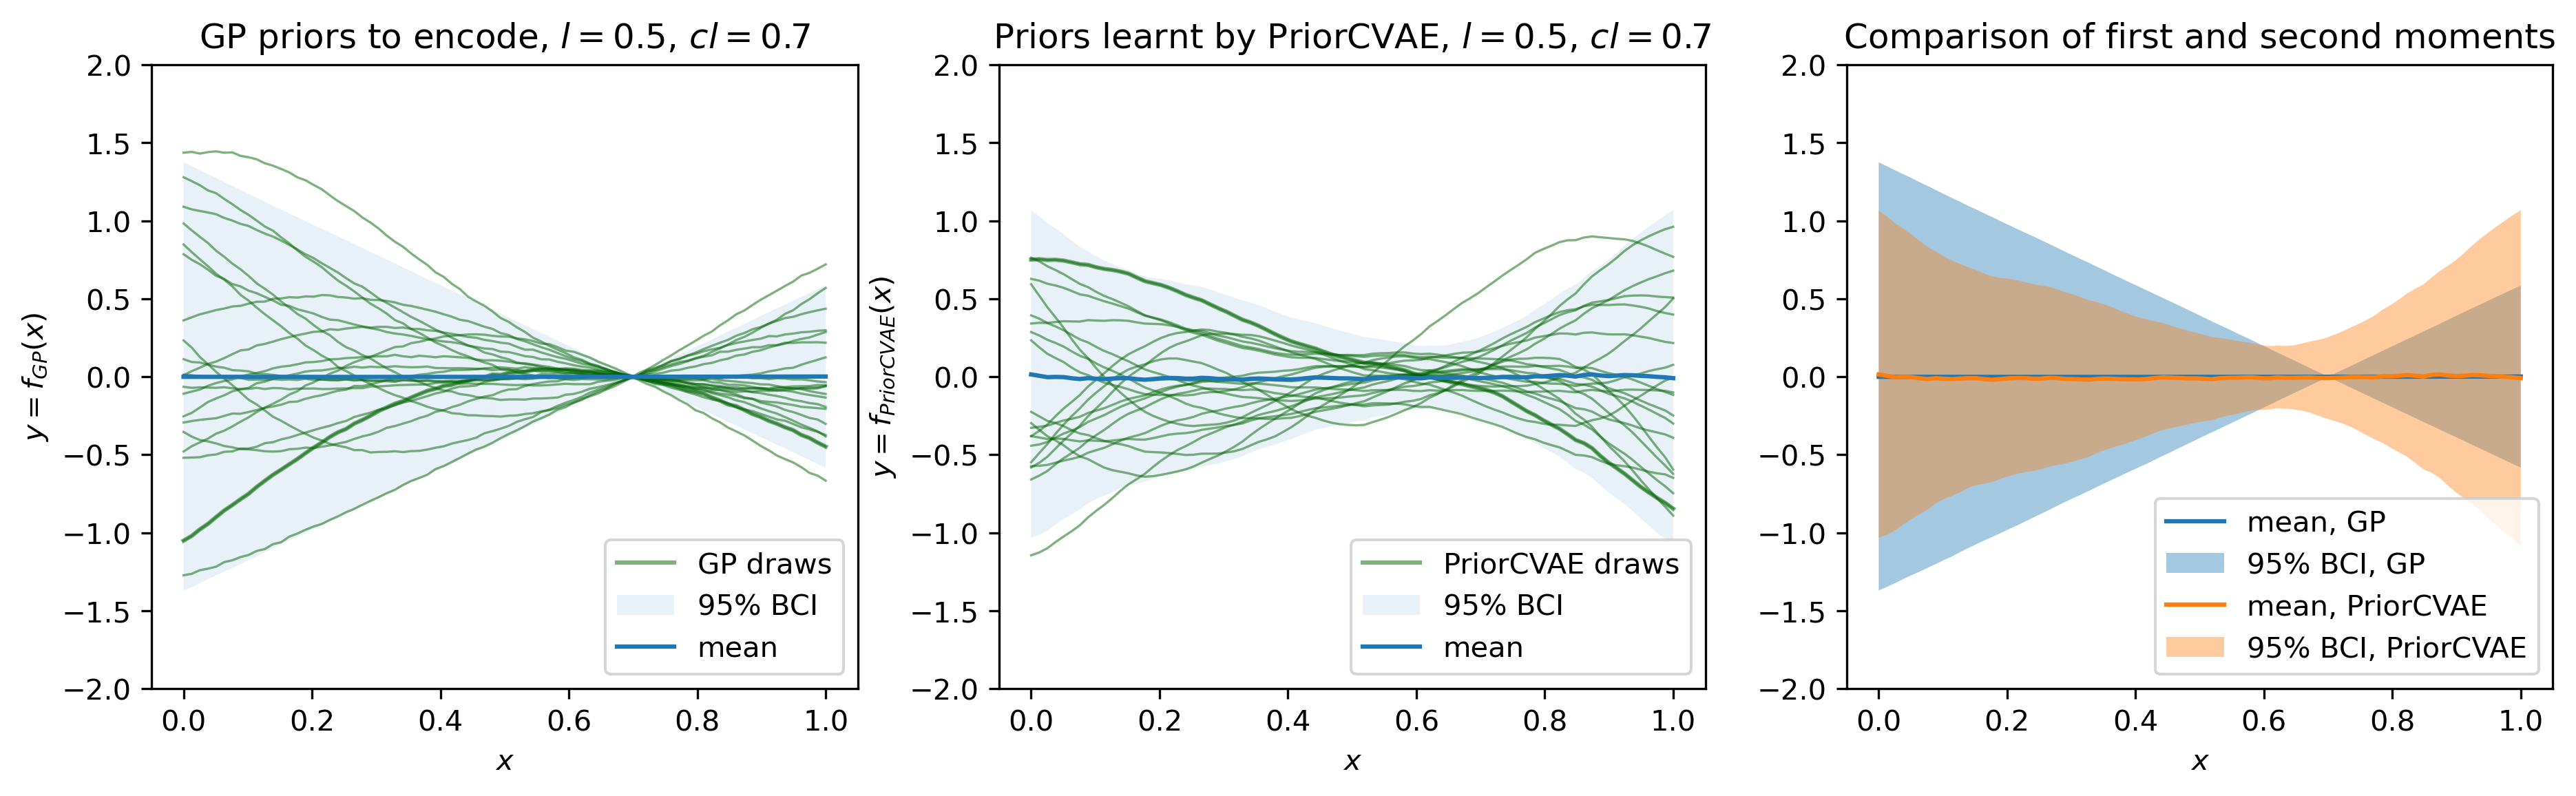

In [47]:
# 4).

demo_plots(conditional=True, ls=0.5, cl=0.7, plot_draws = True, plot_cov =False, print_MMD = False)

plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
#plt.savefig('res/1d_n{}_lin_rbf_priors_ls05.pdf'.format(n))

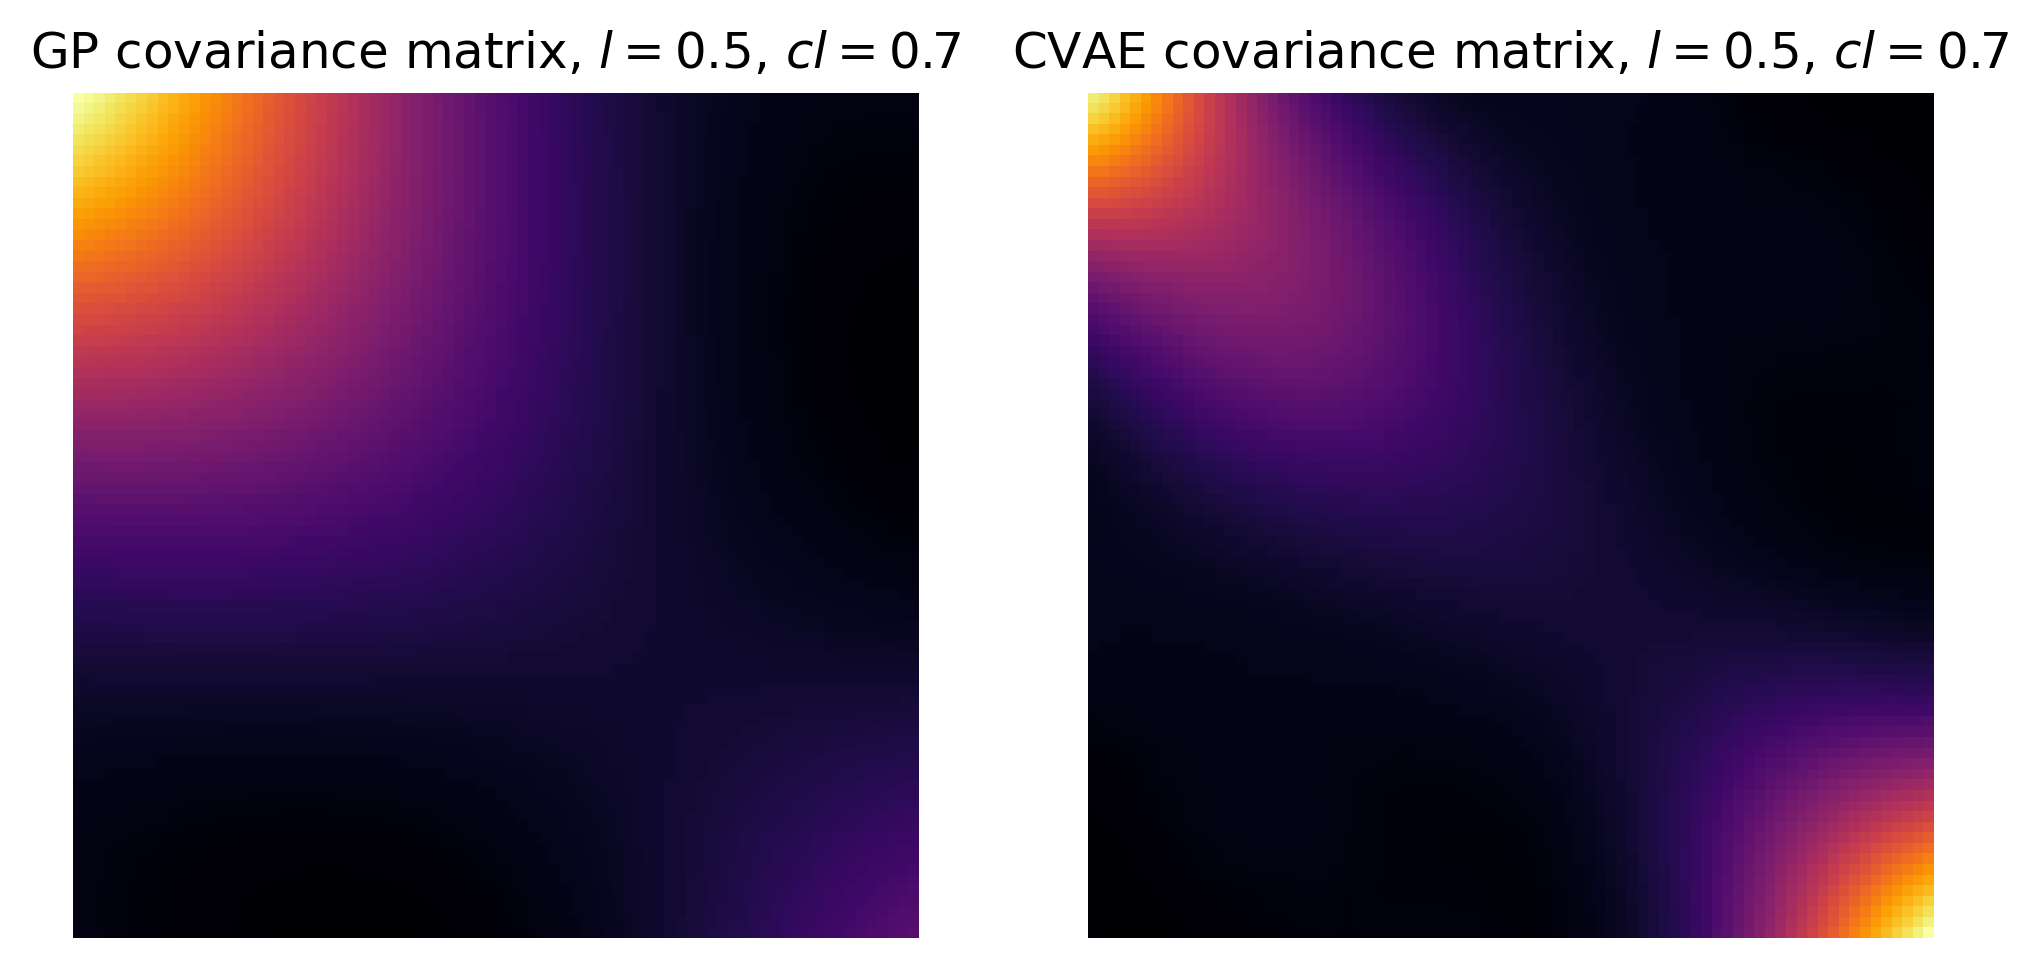

In [50]:
demo_plots(conditional=True, ls=0.5, cl=0.7, plot_draws = False, plot_cov =True, print_MMD = False)

plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 100
#plt.savefig('res/1d_n{}_GP_lin_rbf_cov_mats_ls05.pdf'.format(n))

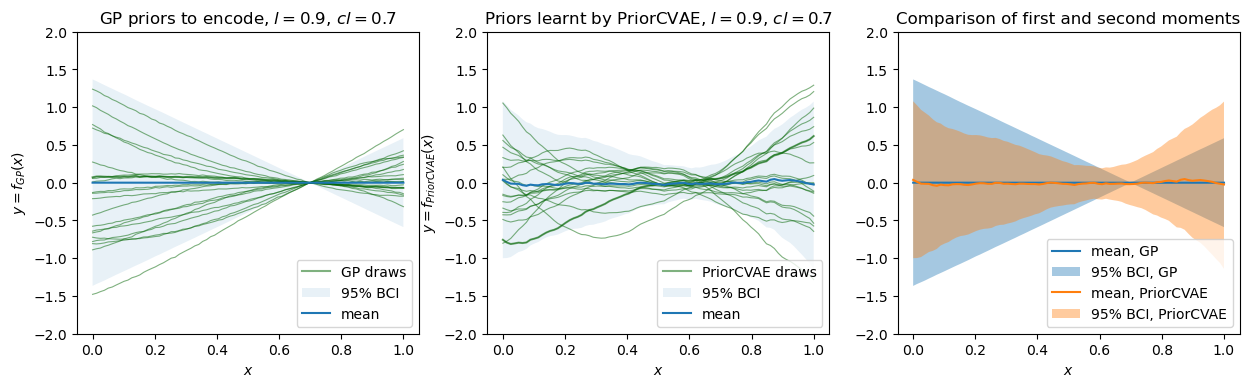

In [51]:
# 4).
demo_plots(conditional=True, ls=0.9, cl=0.7, plot_draws = True, plot_cov =False, print_MMD = False)

plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
#plt.savefig('res/1d_n{}_lin_rbf_priors_ls09.pdf'.format(n))

In [ ]:
demo_plots(conditional=True, ls=0.9, , cl=0.7, plot_draws = False, plot_cov =True, print_MMD = False)

plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 100
#plt.savefig('res/1d_n{}_GP_lin_rbf_cov_mats_ls09.pdf'.format(n))